# Clone and Install Janus
This cell clones the Janus repository from GitHub and installs it as a package in development mode, allowing for easy updates.

In [ ]:
!git clone https://github.com/deepseek-ai/Janus
%cd Janus
!pip install -e .

Cloning into 'Janus'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 121 (delta 51), reused 36 (delta 36), pack-reused 47 (from 2)
Receiving objects: 100% (121/121), 7.19 MiB | 26.67 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/Janus
Obtaining file:///content/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━

# Import Libraries and Initialize Model
This cell imports the necessary dependencies and loads the Janus-Pro-7B model from deepseek-ai. The model is configured to run on GPU with bfloat16 precision for efficient inference.

In [ ]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [ ]:
# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-7B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


processor_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: add_special_token, image_tag, num_image_tokens, sft_format, mask_prompt, ignore_id. 


config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/89.0k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/92.8k [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Configure Conversation Format and Prompt
Here we define the conversation structure between user and assistant, format it using the model's template, and add the image generation tag. This prepares the text prompt that will guide the image creation process.

In [ ]:
# This code takes a conversation between a user and assistant
# and formats it for supervised fine-tuning
conversation = [
    {"role": "<|User|>", "content": "Create a futuristic cityscape with flying vehicles"},
    {"role": "<|Assistant|>", "content": ""},
]

# Apply the SFT template to format the conversation properly
formatted_prompt = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="You are a helpful AI assistant specialized in visual creativity.",
)

# Add the image start tag to indicate where image generation should begin
final_prompt = formatted_prompt + vl_chat_processor.image_start_tag

# Define Image Generation Function
This function handles the complete image generation pipeline using classifier-free guidance:
1. Encodes the text prompt and prepares conditional/unconditional inputs
2. Autoregressively generates image tokens
3. Decodes tokens into RGB images
4. Saves the resulting images to disk

In [ ]:

@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "cat_img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)




In [ ]:
generate(
    vl_gpt,                # The multimodal language model
    vl_chat_processor,     # The processor for handling text and visual data
    final_prompt,                # The text prompt for image generation
)

# Visualize Generated Images
This code creates a 4×4 grid display of the generated images using matplotlib, allowing for visual comparison of multiple outputs from the same prompt.

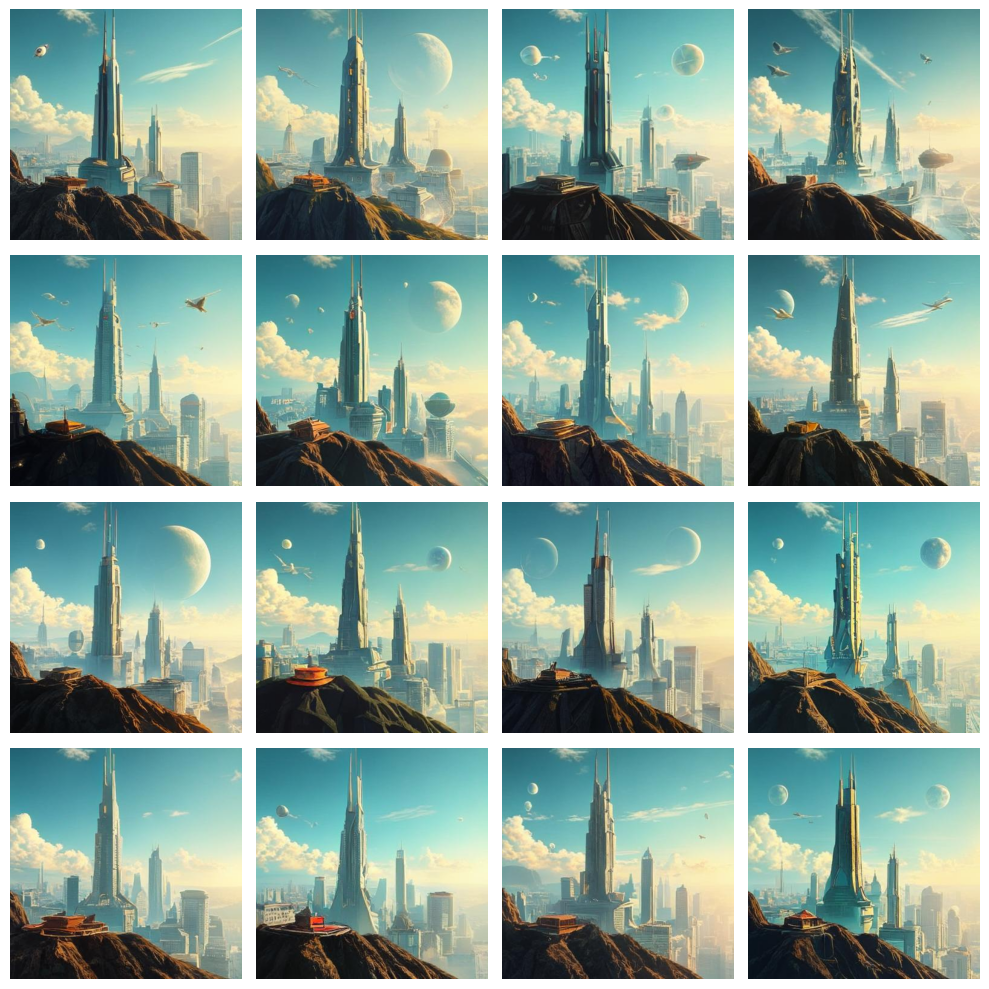

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Path to the directory containing the generated images
image_dir = "/content/Janus/generated_samples"

# Create a figure with a 4x4 grid of subplots (16 images total)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through image files in the directory (limited to first 16)
for i, filename in enumerate(os.listdir(image_dir)[:16]):
    # Only process files with image extensions
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        image_path = os.path.join(image_dir, filename)
        img = mpimg.imread(image_path)

        # Calculate the position in the grid
        row = i // 4
        col = i % 4

        # Display the image in its grid position
        axes[row, col].imshow(img)
        axes[row, col].axis('off')  # Remove axis ticks and labels

# Optimize the layout and display all images
plt.tight_layout()
plt.show()